In [41]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

[*********************100%***********************]  1 of 1 completed


4656 combinations tested


Price,Adj Close,Close,High,Low,Open,Volume,98_ma,99_ma,Strategy,Asset_Returns,Strategy_Returns
1,24.553850,44.250000,44.250000,43.968750,43.968750,480500,44.095344,44.095328,-1.0,0.007112,-0.007112
2,24.605869,44.343750,44.375000,44.125000,44.218750,201300,44.179842,44.179814,1.0,0.009246,-0.005009
3,24.865969,44.812500,44.843750,44.375000,44.406250,529400,44.342881,44.342811,1.0,0.019915,0.005509
4,24.970009,45.000000,45.093750,44.468750,44.968750,531500,44.479723,44.479612,1.0,0.024182,0.009716
5,24.952663,44.968750,45.062500,44.718750,44.968750,492100,44.565442,44.565307,1.0,0.023471,0.009015
...,...,...,...,...,...,...,...,...,...,...,...
8193,643.299988,643.299988,644.000000,642.179993,642.859985,43804900,606.836751,606.613577,1.0,13.641252,2.640511
8194,639.809998,639.809998,644.109985,638.479980,643.119995,69750700,607.502877,607.277505,1.0,13.561821,2.620761
8195,638.109985,638.109985,639.659973,632.950012,639.400024,88890300,608.121203,607.894155,1.0,13.523129,2.611140
8196,635.549988,635.549988,637.969971,633.809998,636.280029,54805800,608.675320,608.447271,1.0,13.464865,2.596653


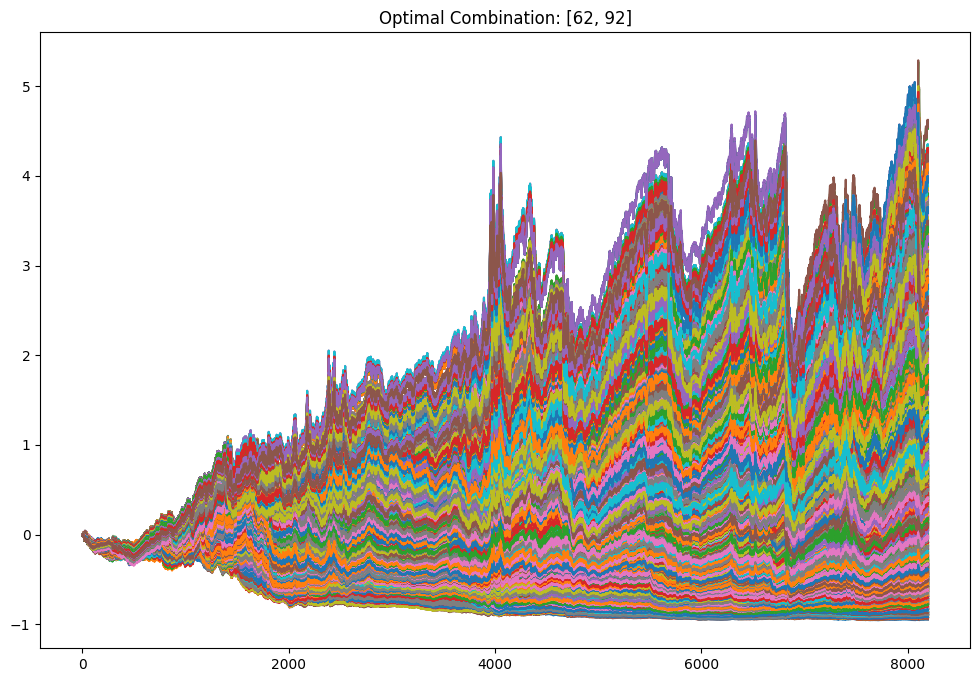

In [42]:
TICKER = 'SPY'
INTERVAL='1d'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'
LOOKBACK = 10000

FAST = list(range(3, 100))
SLOW = list(range(4, 100))

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, auto_adjust=False)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_moving_averages(df, fast, slow):
    df[f'{fast}_ma'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ma'] = df['Close'].ewm(span=slow).mean()

    return df.dropna()

def add_strategy(df, fast, slow):
    
    # long when fast > slow, short otherwise
    df['Strategy'] = np.where(df[f'{fast}_ma'] > df[f'{slow}_ma'], 1, -1)
    df['Strategy'] = df['Strategy'].shift(1)
    return df

def test_strategy(df):
    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.plot(df['Strategy_Returns'])    
    return df.dropna()

def main():
    base = get_data()
    plt.figure(figsize=(12, 8))
    legend_list = []

    best_returns = -np.inf
    best_params = None

    count = 0
    for s in SLOW:
        for f in FAST:
            if f < s:
                df = base.copy()
                df = add_moving_averages(df, f, s)
                df = add_strategy(df, f, s)
                df = test_strategy(df)
                legend_list.append(f'{f}, {s} cross')

                returns = float(df['Strategy_Returns'].iloc[-1])
                if returns > best_returns:
                    best_returns = returns
                    best_params = [f, s]
                
                count += 1

    plt.title(f'Optimal Combination: {best_params}')
    print(f'{count} combinations tested')
    return df

main()